In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import multivariate_t
from scipy.special import hyp2f1

# Comparison of generative models from light tail to heavy tail 
* generative models: 
    * $W1$ proximals: GAN, GPA
        * KL-Lip=1, $\alpha$-Lip=1 with $\alpha=2, 10$, reverse KL-Lip=1
    * $W2$ proximals: OT Flow 
    * $W2$ variant proximals: VE SGM (Variance Exploding SDE forward - heavy->light & reverse SDE - light->heavy), 
* Change df below (df=1.0 or df=3.0)

In [2]:
# true samples
N, d = 10000, 2
df = 3.0
Q_ = multivariate_t(np.zeros(d), np.eye(d), df=df)
true_t = Q_.rvs(size=N, random_state=0)

true_gaussian = np.random.normal(size=(N, d))

In [3]:
from scipy.special import gamma
rdf_t = lambda x: gamma((d+df)/2)/gamma(d/2)/gamma(df/2) * (x**2/df)**(d/2-1) * (2/df*x) * (1+x**2/df)**(-(d+df)/2)
pdf_t = lambda x: gamma((d+df)/2)/gamma(df/2)/(np.pi*df)**(1/2) * (1+x**2/df)**(-(df+1)/2)

reverse_rcdf_t = lambda x: 1 - gamma((d+df)/2)/gamma(df/2)/(df*np.pi)**(d/2) * (df*np.pi)* 2/df * (1- (1+x**2/df)**(-df/2))
reverse_cdf_t = lambda x: 1- 2*(x * gamma((df+1)/2) * hyp2f1(1/2, (df+1)/2, 3/2, -x**2/df) / np.sqrt(np.pi*df)/gamma(df/2))

if df ==1.0:
    xlim = 100
elif df == 2.0:
    xlim = 50
elif df == 3.0:
    xlim = 10
xx = np.linspace(0,xlim, 1000)

rdf_gaussian = lambda x: x*np.exp(-x**2/2)/gamma(1)
xlim_gaussian, ylim_gaussian = 20, 0.75
xx_gaussian = np.linspace(0,xlim_gaussian, 100)

In [4]:
def draw_plots(generated, true, label, beta1, beta2, dist = 'Student-t'):
        
    # radial distribution function and histogram in log-log plot
    if dist=='Student-t':
        binsize = 5000
        reverse_rcdf = reverse_rcdf_t
        reverse_cdf = reverse_cdf_t
    else:
        binsize = 500
        #rcdf = rcdf_gaussian
        # cdf = cdf_gaussian
        
    fig_scale = 3
    
    plt.figure(figsize=(fig_scale,fig_scale)) 
    plt.xscale('log')
    plt.yscale('log')
    radii = np.linalg.norm(generated, axis=1)
    hist = plt.hist(radii[np.argwhere(~np.isnan(radii))], density=True, cumulative=-1, bins=binsize, range = (0, 3*xlim), color='slategray')
    xx = np.linspace(0, xlim, 1000)
    plt.plot(xx, reverse_rcdf(xx), color='red', linestyle='-' , linewidth=2.0, alpha=0.6)
    plt.xlim([1, 100])
    plt.ylim([1/100, 1])

    
    if np.isnan(radii).any():
        plt.annotate("L1 error=NAN", xy=(150, 140), xycoords='axes points',
        size=11, ha='right', va='top')
    else:
        idx = np.argwhere(hist[1]>=1)[0][0]
        hist_x = hist[1][idx:]
        hist_y = hist[0][idx:]
        

        error = sum((hist_x[1:]-hist_x[:-1])*abs(hist_y -reverse_rcdf((hist_x[1:]+hist_x[:-1])/2)))

        plt.annotate(r"L1 error=%.2f" % error, xy=(150, 150), xycoords='axes points',
        size=11, ha='right', va='top')
    
    plt.tight_layout()
    plt.savefig(f"./figures/{label}.png")
    plt.show()

    
    # Scatter plot
    plt.figure(figsize=(fig_scale,fig_scale)) 
    plt.xscale('linear')
    plt.yscale('linear')
    plt.scatter(true[:,0], true[:,1], label='true', alpha=0.5, s=5)
    plt.scatter(generated[:,0], generated[:,1], label="generated", alpha=0.5, s=5)
    plt.legend(fontsize=11)
    
    plt.xlim([-3*xlim, 3*xlim])
    plt.ylim([-3*xlim, 3*xlim])
    plt.tight_layout()
    plt.savefig(f"./figures/{label}_2.png")
    #plt.savefig(f"./figures/{label}_2.eps", format='eps')

    plt.show()

    

## W1 proximals

### $f$-Lip GAN (Learning student-t from Gaussian)

$$\inf_R D_f(R\|Q) + L W_1(P, R)$$

and without proximal

alpha=02.00-Lip=1 GAN


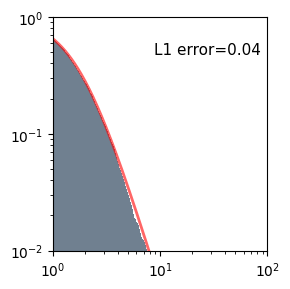

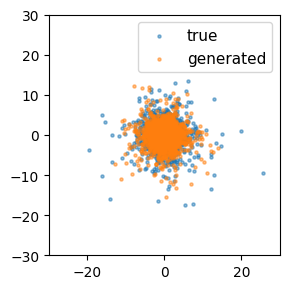

In [5]:
# Lipschitz regularized GAN (Light to Heavy)

beta1 = 'infty'
beta2 = df + d
#fs = ['KL', 'alpha=02.00', 'alpha=10.00', 'reverse_KL', 'reverse_alpha=02.00',]
fs = ['alpha=02.00',]

for f in fs:
    #fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    filename = "assets/Learning_student_t/%s-Lipschitz_1.0000_GAN_df%.2f_10000samples_0.pickle" % (f, df)
    
    with open(filename, "rb") as fr:
        [generated] = pickle.load(fr)
    
    print(f"{f}-Lip=1 GAN")
    draw_plots(generated, true_t, f"{f}-Lip=1 GAN df={df}", beta1, beta2)


alpha=02.00 GAN


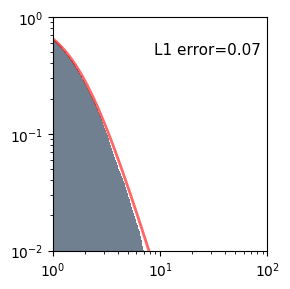

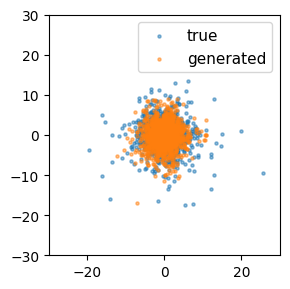

In [6]:
# GAN (Light to Heavy)
beta1 = 'infty'
beta2 = df + d
#fs = ['KL', 'alpha=02.00', 'alpha=10.00',]# 'reverse_KL', 'reverse_alpha=02.00',]
fs = ['alpha=02.00',]

for f in fs:
    #fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    filename = "assets/Learning_student_t/%s-Lipschitz_inf_GAN_df%.2f_10000samples_0.pickle" % (f, df)
    
    with open(filename, "rb") as fr:
        [generated] = pickle.load(fr)
        
    print(f"{f} GAN")
    draw_plots(generated, true_t, f"{f} GAN df={df}", beta1, beta2)
    


### $f$-Lip GPA (Learning student-t from Gaussian)

$$\inf_R D_f(R\|Q) + L W_1(P, R)$$
and without proximal

alpha=02.00-Lip=1 GPA


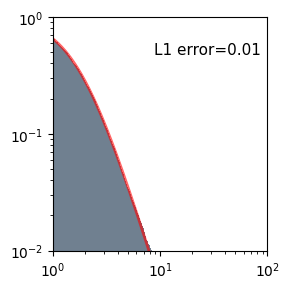

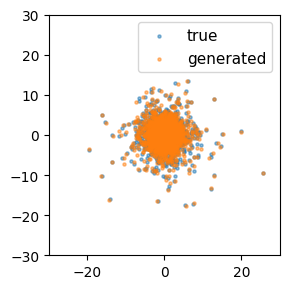

In [7]:
# Lipschitz regularized GPA (Light to Heavy)

fs = ['alpha=02.00', ]# 'reverse_KL', ]
beta1 = 'infty'
beta2 = df + d

for f in fs:
    if f in ['KL', 'reverse_KL']:
        alias_f = f + '=02.00'
    else:
        alias_f = f
    if df == 1.0:
        filename = "assets/Learning_student_t/%s-Lipschitz_1.0000_%.2f_10000_10000_00_1.pickle" % (alias_f, df)
    else:
        filename = "assets/Learning_student_t/%s-Lipschitz_1.0000_%.2f_10000_10000_00_a_trial.pickle" % (alias_f, df)

    with open(filename, "rb") as fr:
        param, result = pickle.load(fr)
        
    print(f"{f}-Lip=1 GPA")
    draw_plots(result['trajectories'][-1], true_t, f"{f}-Lip=1 GPA df={df}", beta1, beta2)



alpha=02.00 GPA


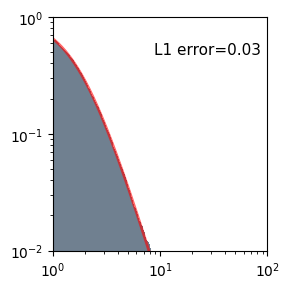

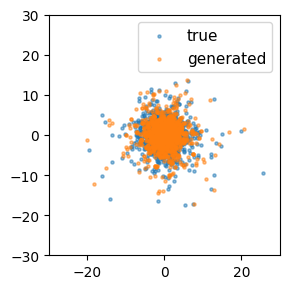

In [8]:
# GPA (Light to Heavy) without proximal
fs = ['alpha=02.00']#, 'alpha=10.00', ]#'reverse_KL', ]
beta1 = 'infty'
beta2 = df + d

for f in fs:
    if f in ['KL', 'reverse_KL']:
        alias_f = f + '=02.00'
    else:
        alias_f = f
    filename = "assets/Learning_student_t/%s-Lipschitz_inf_%.2f_10000_10000_00_a_trial.pickle" % (alias_f, df)
    
    with open(filename, "rb") as fr:
        param, result = pickle.load(fr)
        
    print(f"{f} GPA")
    draw_plots(result['trajectories'][-1], true_t, f"{f} GPA df={df}", beta1, beta2)


## W2 proximals (flow models)

### OT flow
$$\inf_R D_{KL}(Q\|R) + C W_2^2(P, R)$$

OT flow T=10


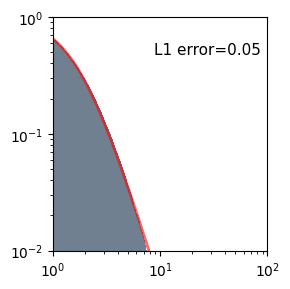

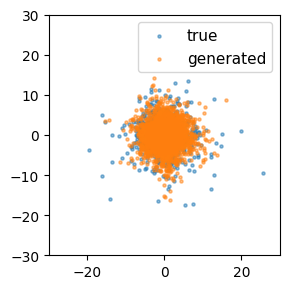

In [9]:
# OT flow (T=10)
beta1 = 'infty'
beta2 = df + d

filename = f"assets/student-t/otflow_df{df}_10000samples.pickle"
with open(filename, "rb") as fr:
    [normalized, generated] = pickle.load(fr)
        
print(f"OT flow T=10")
draw_plots(generated, true_t, f"OT flow T=10 df={df}", beta1, beta2)


CNF T=10


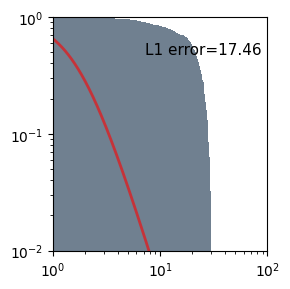

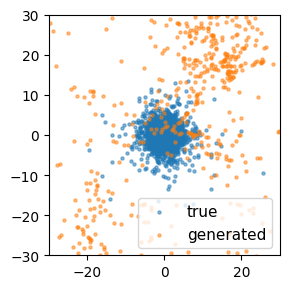

In [10]:
# No-OT flow (T=10)

beta1 = 'infty'
beta2 = df + d

filename = f"assets/student-t/no_otflow_df{df}_10000samples.pickle"
with open(filename, "rb") as fr:
    [normalized, generated] = pickle.load(fr)
        
print(f"CNF T=10")
draw_plots(generated, true_t, f"CNF T=10 df={df}", beta1, beta2)


## SGM with different f
$$\inf_R -E_R(\log Q) + \int_0^T \int_{\mathbb{R}^d} \left(\frac{1}{2}|v(x,t)|^2 - \nabla \cdot f (x,t) \right) \rho(x,t)dx dt$$
where $f$ is the drift of diffusion process.

VE SGM


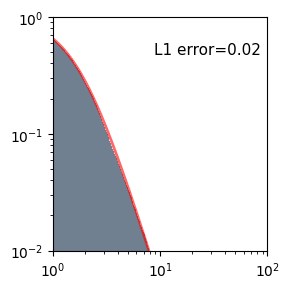

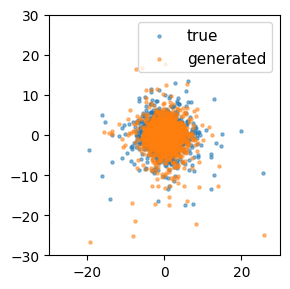

In [11]:
# VE-sgm with  (f=0)
beta1 = 'infty'
beta2 = df + d

filename = f"assets/student-t/ve_sgm_df{df}_10000samples.pickle"
with open(filename, "rb") as fr:
    ou_normal, ou_reverse = pickle.load(fr)

print(f"VE SGM")
draw_plots(ou_reverse, true_t, f"VE SGM df={df}", beta1, beta2)

